# Вводная часть

### Задание

Требуется провести анализ изменения цены лечения в 2022 году относительно 2021 года в медицинской клинике и определить ключевые драйверы изменения цены лечения. 

**Определение:** медицинский кейс — последовательность медицинских услуг, полученных одним застрахованным в одной клинике с интервалом между любыми соседними по дате услугами не более 14 дней. Т.е. между любыми 2-мя соседними услугами в кейсе не должно быть разрыва более 14 дней.

**Определение:** визит — уникальное сочетание даты оказания услуги, застрахованного. Т.е. один визит — это один день, в который застрахованный побывал в клинике. Если был в одной клинике 2 раза, но в разные дни, то это два визита. Если получал услуги (в любом количестве) в одной клинике в один день, то это один визит.

**Определение:** обратившийся в месяц — уникальное сочетание месяца оказания услуги и идентификатора пациента.

**Гипотезы для проверки, приблизительный список:**

1. Средняя стоимость обслуживания пациентов изменилась из-за изменения цен на услуги
2. Средняя стоимость обслуживания изменилась из-за изменения интенсивности лечения пациентов
3. Средняя стоимость обслуживания пациентов изменилась из-за изменения поло-возрастной структуры обслуживаемых пациентов
4. Средняя стоимость обслуживания пациентов изменилась из-за изменения структуры оказываемых услуг (раньше были дорогие услуги, теперь дешевые или наоборот)
5. Средняя стоимость обслуживания изменилась из-за изменения среднего количества оказанных услуг на один кейс
6. Другие гипотезы на усмотрение кандидата

Кандидат должен выдвинуть и проверить от 3-х до 6-ти основных гипотез. Проверка каждой гипотезы должна содержать:

- Формулировку гипотезы
- Описание (определение) показателей, которые требуется рассчитать для проверки гипотезы
- Расчет выбранных показателей на доступных данных
- Вывод о подтверждении или опровержении гипотезы на основе данных и расчет влияния данного фактора на повышение средней стоимости

Также требуется сформулировать 1 или несколько основных показателей, описывающих стоимость лечения, относительно которых будет формулироваться гипотеза. 
Например: показатель “средняя стоимость лечения одного пациента за один месяц” изменился на ХХ% из-за повышения цены на услуги на YY%

### Описание данных

- record_id- уникальный идентификатор строки данных
- service_date - дата оказания медицинской услуги
- service_name - наименование медицинской услуги
- service_number - количество услуг
- service_amount - сумма выплат (стоимость оказанных услуг в рублях)
- insured - уникальный идентификатор пациента
- sex_id - пол пациента
- age_for_service_date - возраст пациента

Все данные взяты из одной клиники

# Процедуры и функции

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib import colors
from matplotlib import colormaps
import calendar
import scipy.stats as stats
import numpy as np

In [2]:
#pd.options.display.precision=2
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', 1000)

In [3]:
# Формирование таблицы кейсов

def medcase_count(year_data):
    medcase = pd.DataFrame([])
    insured = year_data['insured'].unique()
    for i in insured:
        dd = year_data.query('insured == @i')[['insured', 'date']].sort_values(by='date')
        dd['dif_day'] = dd['date'] - dd['date'].shift(1)  
        medcase = pd.concat([medcase, dd])
    medcase['dif_day'] = medcase['dif_day'].dt.days
    medcase['dif_day'] = medcase['dif_day'].fillna(99)
    medcase['newcase'] = medcase['dif_day'].apply(lambda x: 1 if x > 14 else 0)
    return medcase

In [4]:
# Вывод проверки выброк для тестирования
def chek_dd_test(d_test1, d_test2):
    norm1 = False
    norm2 = False
    pval = stats.normaltest(d_test1)[1]
    if pval < 0.05:
        print(f'Первая выборка размером {len(d_test1)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
    else:
        print(f'Первая выборка размером {len(d_test1)} прошла проверку на нормальное распределение. pval = {pval}')
        norm1 = True

    pval = stats.normaltest(d_test2)[1]
    if pval < 0.05:
        print(f'Вторая выборка размером {len(d_test2)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
    else:
        print(f'Вторая выборка размером {len(d_test2)} прошла проверку на нормальное распределение. pval = {pval}')
        norm2 = True

    equal_var = False
    pval = stats.levene(d_test1, d_test2)[1]
    if pval < 0.05:
        print(f'Дисперсии выборок НЕ близки. pval = {pval}. Применяем equal_var=False')
    else:
        print(f'Дисперсии выборок близки. pval = {pval}. Применяем equal_var=True ')
        equal_var = True
    return norm1, norm2, equal_var

In [5]:
# Вывод результатов тестирования в зависимост от pvalue
def pval_print (pval, h0='', h1=''):
    print('В результате теста получено p-value', pval)
    if pval < 0.05:
        print('НЕ можем принять нулевую гипотезу, принимаем альтернативную:')
        print(' ------> \033[31m\033[1m', h1, '\033[0m')
    else:
        print('НЕ можем отвергнуть нулевую гипотезу, принимаем ее:')
        print(' ------> \033[32m\033[1m', h0, '\033[0m')

In [6]:
# Тестирование сравнения двух выборок
# Greater в контексте t-теста на Python означает, что 
# среднее значение распределения первой выборки больше, чем у второй.

def test_selection (d_test1, d_test2, side='two-sided', h0='', h1=''):
    norm1, norm2, e_var = chek_dd_test(d_test1, d_test2)
    l1 = (len(d_test1) >= 30)
    l2 = (len(d_test2) >= 30)
    print()
    if (norm1 & norm2): print('Обе выборки имеют нормальное распределение!')
    if ((l1 or norm1) and (l2 or norm2)) :
        if (l1 & l2): print(f'Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest')
        print()
        print('--- Проводим TTest ---')
        pval = stats.ttest_ind(d_test1, d_test2, alternative = side, equal_var=e_var)[1]
        pval_print(pval, h0, h1)
        print()
        print('Для сравнения проведем и параметрический тест Манна-Уитни')
        print()
    else:
        print(f'Выборки маленькие ({len(d_test1)} / {len(d_test2)}) - НЕЛЬЗЯ применять ttest')

    print('---- Проводим Test Mann-Whitneyu ----')
    pval = stats.mannwhitneyu(d_test1, d_test2, alternative = side)[1]
    pval_print(pval, h0, h1)

In [7]:
#подсветка ячеек, значения которых меньше 0.05
def highlight_over(s, color='lime', p = 0.5):
      return ['background-color: '+color if val > p else 'background-color: none' for val in s]

In [8]:
#подсветка ячеек, значения которых меньше 0.05
def highlight_stat(s, color='orange'):
    return ['background-color: '+color if val < 0.05 else 'background-color: none' for val in s]

# Загрузка данных

In [9]:
path = 'd:/newwork/MainsLab/data_test_task_2022.xlsx'

In [10]:
data = pd.read_excel(path)

In [11]:
data.head(10)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.00,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",284,1,490777,2.00,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам",1134,1,490777,2.00,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.00,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.00,26
5,30268157503,2021-01-24,С-реактивный белок,420,1,490777,2.00,26
6,30268157603,2021-01-24,Взятие крови из периферической вены,158,1,490777,2.00,26
7,30268157703,2021-01-26,Прием первичный,1470,1,490777,2.00,26
8,30268157803,2021-01-26,Магнитотерапия (1 сеанс),1040,1,490777,2.00,26
9,30268157903,2021-01-26,УВЧ-терапия (1 сеанс) (1 поле),1040,1,490777,2.00,26


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB


# Предобработка данных

## Проверка на пропуски

In [13]:
data.isna().sum()

record_id                0
service_date             0
service_name             0
service_amount           0
service_number           0
insured                  0
sex_id                  21
age_for_service_date     0
dtype: int64

In [14]:
data[data['sex_id'].isna()]

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
4411,30489299203,2021-03-18,Прием первичный,1470,1,512590,NaN,26
4412,30489299303,2021-03-27,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,512590,NaN,26
4413,30489299403,2021-03-27,Общий анализ мочи,431,1,512590,NaN,26
4414,30489299503,2021-03-27,Альфа-амилаза панкреатическая,287,1,512590,NaN,26
4415,30489299603,2021-03-27,АЛТ (аланинаминотрансфераза),278,1,512590,NaN,26
4416,30489299703,2021-03-27,АСТ (аспартатаминотрансфераза),242,1,512590,NaN,26
4417,30489299803,2021-03-27,Билирубин общий,287,1,512590,NaN,26
4418,30489299903,2021-03-27,ГГТ (гамма - глютамилтрансфераза),287,1,512590,NaN,26
4419,30489300003,2021-03-27,Глюкоза крови,273,1,512590,NaN,26
4420,30489300103,2021-03-27,Фосфотаза щелочная,287,1,512590,NaN,26


У двух пациентов не указан пол - не критично. Оставляем как есть

## Проверка на дубликаты

In [15]:
data.duplicated().sum()

0

Дубликатов нет

## Обрабокта отдельных колонок

### Приводим дату к типу datetime

In [16]:
data['date'] = pd.to_datetime(data['service_date'], format = '%Y-%m-%d', errors = 'coerce')

Сразу создадим колонки с годом, месяцем и неделей оказания услуги.

In [17]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week

Определяем границы периода данных в датасете.

In [18]:
print(f"Сaмая раняя дата {data['date'].min()}, самая поздняя дата {data['date'].max()}")

Сaмая раняя дата 2021-01-03 00:00:00, самая поздняя дата 2022-08-31 00:00:00


In [19]:
data.groupby(['year', 'month'])['record_id'].count()

year  month
2021  1        2021
      2        2120
      3        3696
      4        3869
      5        3788
      6        3915
      7        3545
      8        3782
      9        4229
      10       5065
      11       4074
      12       4288
2022  1        4143
      2        4586
      3        5547
      4        6692
      5        6374
      6        5765
      7        4841
      8        3029
Name: record_id, dtype: int64

Данные за 2022 год неполные — только по август.

### Гендер

Определяем, как кодируются женщины по характерным услугам

In [20]:
data.query('service_name.str.match("Гинек")')['sex_id'].value_counts()

sex_id
2.00    1194
Name: count, dtype: int64

2 - это женщины

In [21]:
data['gender'] = data['sex_id'].apply(lambda x: 'Жен' if x == 2 else 'Муж')

### Прайс на услуги

Определяем, в колонке service_amount прайсовая цена за одну услугу или общая за несколько?

In [22]:
data[data['service_number'] == 2].head(5)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,date,year,month,week,gender
123,30268169303,2021-01-17,Удаление серных пробок (за ухо),1324,2,243480,1.00,34,2021-01-17,2021,1,2,Муж
178,30268174803,2021-01-15,Взятие мазка,682,2,221536,1.00,35,2021-01-15,2021,1,2,Муж
228,30268179803,2021-01-30,Рефрактометрия,1428,2,362887,2.00,31,2021-01-30,2021,1,4,Жен
402,30268197203,2021-01-04,Взятие материала для цитологического исследования,568,2,176388,2.00,39,2021-01-04,2021,1,1,Жен
407,30268197703,2021-01-11,Рефрактометрия,1428,2,176388,2.00,39,2021-01-11,2021,1,2,Жен


In [23]:
data[data['service_name'] == "Рефрактометрия"].head(5)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,date,year,month,week,gender
228,30268179803,2021-01-30,Рефрактометрия,1428,2,362887,2.00,31,2021-01-30,2021,1,4,Жен
230,30268180003,2021-01-21,Рефрактометрия,714,1,346621,2.00,39,2021-01-21,2021,1,3,Жен
274,30268184403,2021-01-22,Рефрактометрия,714,1,490772,2.00,35,2021-01-22,2021,1,3,Жен
350,30268192003,2021-01-23,Рефрактометрия,714,1,488030,2.00,23,2021-01-23,2021,1,3,Жен
384,30268195403,2021-01-16,Рефрактометрия,714,1,490825,2.00,25,2021-01-16,2021,1,2,Жен


В колонке service_amount - общая цена за несколько услуг. Вычислим прайсовую цену одной услуги.

In [24]:
data['price'] = round(data['service_amount'] / data['service_number'], 2)

# Исследовательский анализ данных

Так как данные за 2022 год только по август, для сравнения год к году возьмем данные только за первые 8 месяцев

In [25]:
data2021 = data.query('year == 2021 and month <= 8').copy().reset_index(drop=True)
data2022 = data.query('year == 2022 and month <= 8').copy().reset_index(drop=True)

## Общие показатели

In [26]:
#вычисление количества кайсов перебором. 
#долго, но лучше способа не придумал

medcase2021 = medcase_count(data2021)
medcase2022 = medcase_count(data2022)

Вычисление основных общих показателей и их сравнение год к году

In [27]:
compare = pd.DataFrame(columns = ['Показатель','2021' , '2022'])
compare.loc[0] = ['Общее количество услуг', data2021['service_number'].count(), data2022['service_number'].count()]
compare.loc[1] = ['Общее количество пациентов', data2021['insured'].nunique(), data2022['insured'].nunique()]
compare.loc[2] = ['Общая стомиость услуг', data2021['service_amount'].sum(), data2022['service_amount'].sum()]
compare.loc[3] = ['Общее количество визитов', data2021.groupby(['month', 'date'], as_index=False)['insured'].nunique()['insured'].sum(),
                  data2022.groupby(['month', 'date'], as_index=False)['insured'].nunique()['insured'].sum()]
compare.loc[4] = ['Общее количество кейсов', medcase2021['newcase'].sum(), medcase2022['newcase'].sum()]


compare.loc[5] = ['Средняя стоимость одной услуги', 
                  round(compare.loc[2, '2021'] / compare.loc[0, '2021'], 2),
                  round(compare.loc[2, '2022'] / compare.loc[0, '2022'], 2)]

compare.loc[6] = ['*** Средняя стоимость обслуживания пациента ***', 
                  round(compare.loc[2, '2021'] / compare.loc[1, '2021'], 2),
                  round(compare.loc[2, '2022'] / compare.loc[1, '2022'], 2)]

compare.loc[7] = ['Средняя стоимость одного визита', 
                  round(compare.loc[2, '2021'] / compare.loc[3, '2021'], 2),
                  round(compare.loc[2, '2022'] / compare.loc[3, '2022'], 2)]

compare.loc[8] = ['Средняя стоимость одного кейса', 
                  round(compare.loc[2, '2021'] / compare.loc[4, '2021'], 2),
                  round(compare.loc[2, '2022'] / compare.loc[4, '2022'], 2)]


compare.loc[9] = ['Среднее количество услуг на пациента', 
                  round(compare.loc[0, '2021'] / compare.loc[1, '2021'], 2),
                  round(compare.loc[0, '2022'] / compare.loc[1, '2022'], 2)]

compare.loc[10] = ['Среднее количество визитов на пациента', 
                  round(compare.loc[3, '2021'] / compare.loc[1, '2021'], 2),
                  round(compare.loc[3, '2022'] / compare.loc[1, '2022'], 2)]


compare.loc[11] = ['Среднее количество услуг на кейс', 
                   round(compare.loc[0, '2021'] / compare.loc[4, '2021'], 2),
                   round(compare.loc[0, '2022'] / compare.loc[4, '2022'], 2)]

compare.loc[12] = ['Среднее количество визитов на кейс', 
                   round(compare.loc[3, '2021'] / compare.loc[4, '2021'], 2),
                   round(compare.loc[3, '2022'] / compare.loc[4, '2022'], 2)]


compare['Разница'] = compare['2022'] - compare['2021']
compare['Рост %'] = round(100 * (compare['2022'] / compare['2021'] - 1), 2)

compare

,Показатель,2021,2022,Разница,Рост %
0,Общее количество услуг,26736.00,40977.00,14241.00,53.27
1,Общее количество пациентов,1733.00,2757.00,1024.00,59.09
2,Общая стомиость услуг,29957552.00,48986662.00,19029110.00,63.52
3,Общее количество визитов,9407.00,14434.00,5027.00,53.44
4,Общее количество кейсов,2859.00,4338.00,1479.00,51.73
5,Средняя стоимость одной услуги,1120.49,1195.47,74.98,6.69
6,*** Средняя стоимость обслуживания пациента ***,17286.53,17768.10,481.57,2.79
7,Средняя стоимость одного визита,3184.60,3393.84,209.24,6.57
8,Средняя стоимость одного кейса,10478.33,11292.45,814.12,7.77
9,Среднее количество услуг на пациента,15.43,14.86,-0.57,-3.69


Интересно, что суммарные показатели выросли на 50-60%, а вот средние изменились разнонаправленно: стоимостные показатели выросли на 6-7%, а вот количество услуг/визитов на одного пациента вообще снизилось на 3,5-3,7%. 

При этом целевой показатель "Средняя стоимость обслуживания пациента" вырос всего на 2,8%.

## Динамика основных показателей

Рассчитаем основные показатели по месяцам, чтобы проследить их динамику

In [28]:
monthly_2021 = data2021.groupby('month').agg({'insured' : 'nunique', 'service_amount' : 'sum', 'service_number' : 'sum'})
monthly_2021['visits'] = data2021.groupby(['month', 'date'], as_index=False)['insured'].nunique()\
            .groupby('month')['insured'].sum()
monthly_2021['amount_insured'] = monthly_2021['service_amount'] / monthly_2021['insured']
monthly_2021['amount_visit'] = monthly_2021['service_amount'] / monthly_2021['visits']
monthly_2021['visit_insured'] = monthly_2021['visits'] / monthly_2021['insured']
monthly_2021['service_insured'] = monthly_2021['service_number'] / monthly_2021['insured']


monthly_2022 = data2022.groupby('month').agg({'insured' : 'nunique', 'service_amount' : 'sum', 'service_number' : 'sum'})
monthly_2022['visits'] = data2022.groupby(['month', 'date'], as_index=False)['insured'].nunique()\
            .groupby('month')['insured'].sum()
monthly_2022['amount_insured'] = monthly_2022['service_amount'] / monthly_2022['insured']
monthly_2022['amount_visit'] = monthly_2022['service_amount'] / monthly_2022['visits']
monthly_2022['visit_insured'] = monthly_2022['visits'] / monthly_2022['insured']
monthly_2022['service_insured'] = monthly_2022['service_number'] / monthly_2022['insured']

Строим графики динамика основным показателей

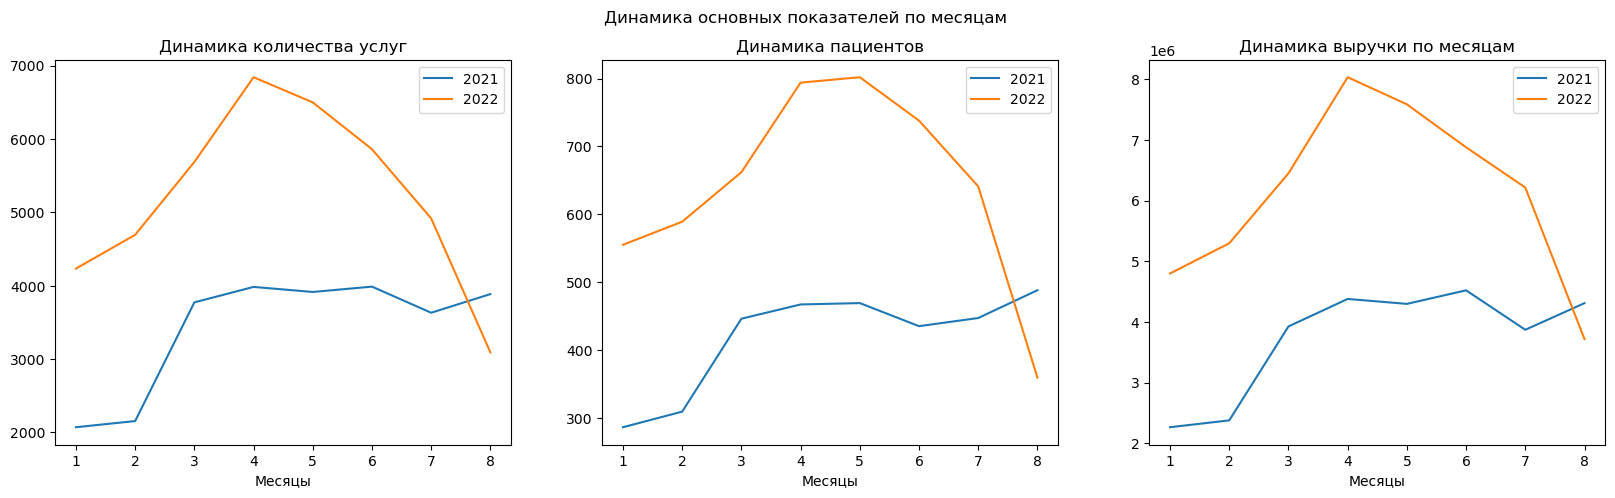

In [29]:
f, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].plot(monthly_2021['service_number'], label = '2021')
ax[0].plot(monthly_2022['service_number'], label = '2022')
ax[0].set_title('Динамика количества услуг')
ax[0].set_xlabel('Месяцы')
ax[0].legend()

ax[1].plot(monthly_2021['insured'], label = '2021')
ax[1].plot(monthly_2022['insured'], label = '2022')
ax[1].set_title('Динамика пациентов')
ax[1].set_xlabel('Месяцы')
ax[1].legend()

ax[2].plot(monthly_2021['service_amount'], label = '2021')
ax[2].plot(monthly_2022['service_amount'], label = '2022')
ax[2].set_title('Динамика выручки по месяцам')
ax[2].set_xlabel('Месяцы')
ax[2].legend()

plt.suptitle('Динамика основных показателей по месяцам')
plt.show()

Как видно из графиков, чтото произошло в мае 2022 года, после чего показатели начали резко падать

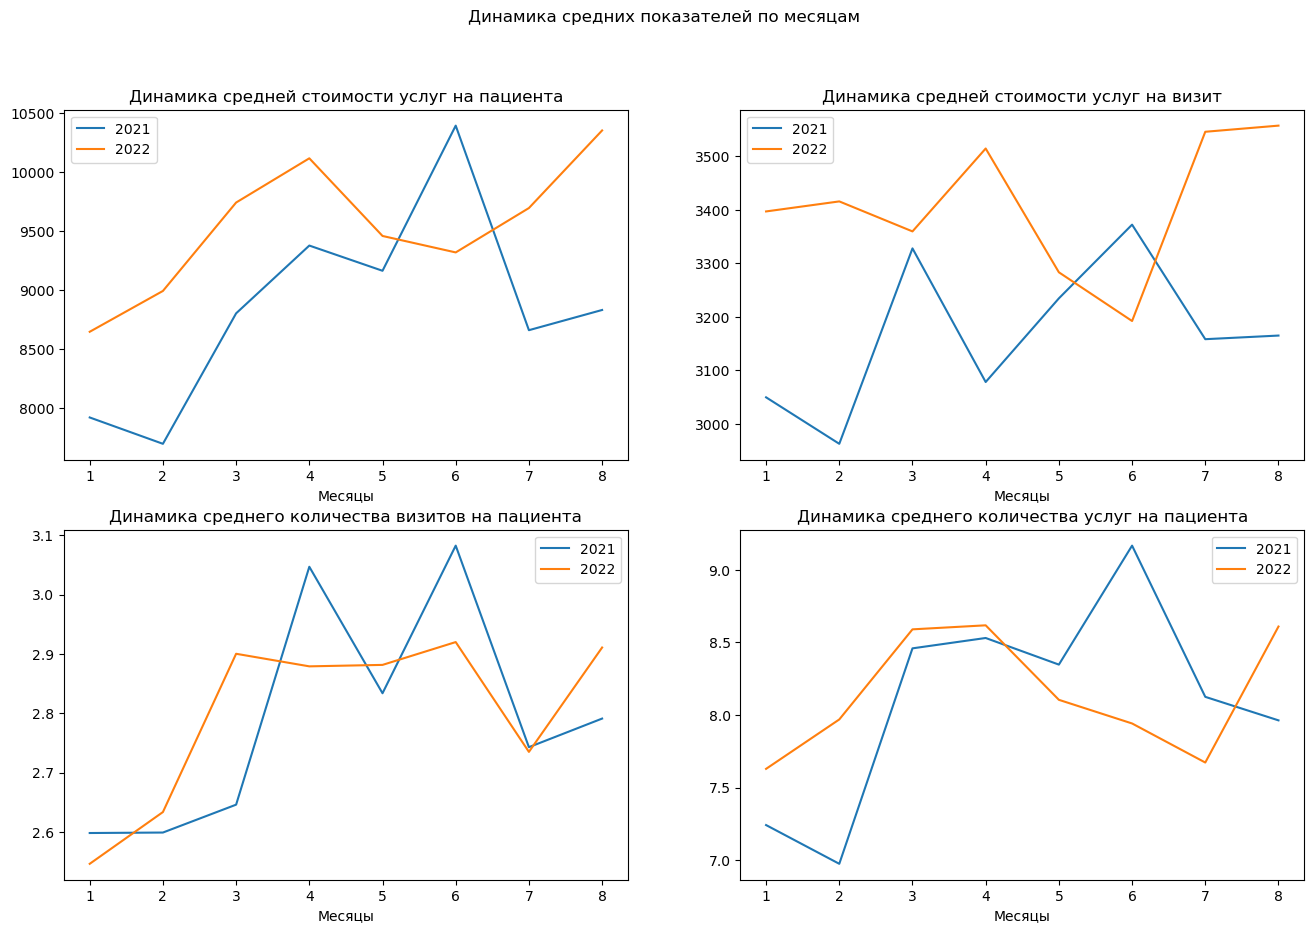

In [30]:
f, ax = plt.subplots(2, 2, figsize=(16,10))
ax[0, 0].plot(monthly_2021['amount_insured'], label = '2021')
ax[0, 0].plot(monthly_2022['amount_insured'], label = '2022')
ax[0, 0].set_title('Динамика средней стоимости услуг на пациента')
ax[0, 0].set_xlabel('Месяцы')
ax[0, 0].legend()

ax[0, 1].plot(monthly_2021['amount_visit'], label = '2021')
ax[0, 1].plot(monthly_2022['amount_visit'], label = '2022')
ax[0, 1].set_title('Динамика средней стоимости услуг на визит')
ax[0, 1].set_xlabel('Месяцы')
ax[0, 1].legend()


ax[1, 0].plot(monthly_2021['visit_insured'], label = '2021')
ax[1, 0].plot(monthly_2022['visit_insured'], label = '2022')
ax[1, 0].set_title('Динамика среднего количества визитов на пациента')
ax[1, 0].set_xlabel('Месяцы')
ax[1, 0].legend() 

ax[1, 1].plot(monthly_2021['service_insured'], label = '2021')
ax[1, 1].plot(monthly_2022['service_insured'], label = '2022')
ax[1, 1].set_title('Динамика среднего количества услуг на пациента')
ax[1, 1].set_xlabel('Месяцы')
ax[1, 1].legend() 


plt.suptitle('Динамика средних показателей по месяцам')
plt.show()

Каких-то очевидных трендов из графиков средних показателей не просматривается

## Гендерное распределение пациентов

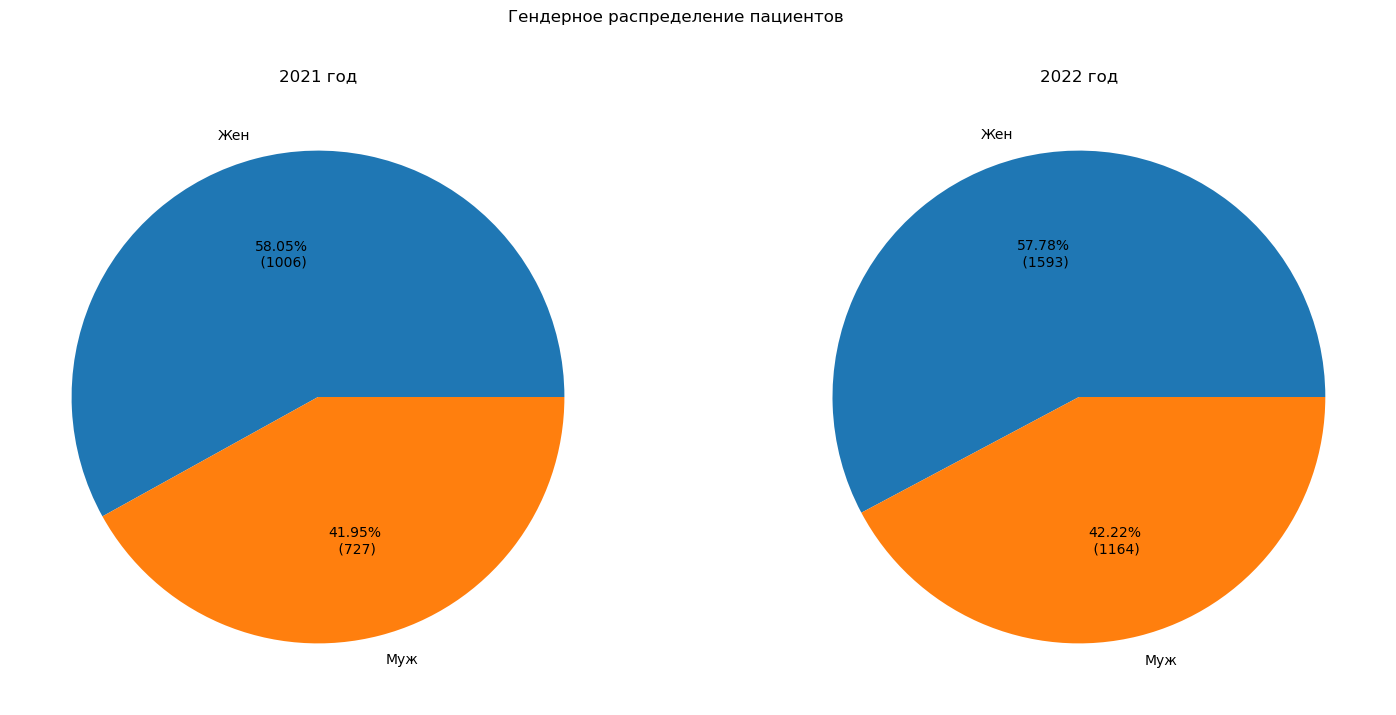

In [31]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
dd = data2021.groupby('gender')['insured'].nunique()
ax[0].pie(x = dd, labels = dd.index,  autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))
ax[0].set_title('2021 год')

dd = data2022.groupby('gender')['insured'].nunique()
ax[1].pie(x = dd, labels = dd.index,  autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))
ax[1].set_title('2022 год')
plt.suptitle('Гендерное распределение пациентов')
plt.show()

В гендерном распределении существенно ничего не поменялось

## Возрастное распределение пациентов

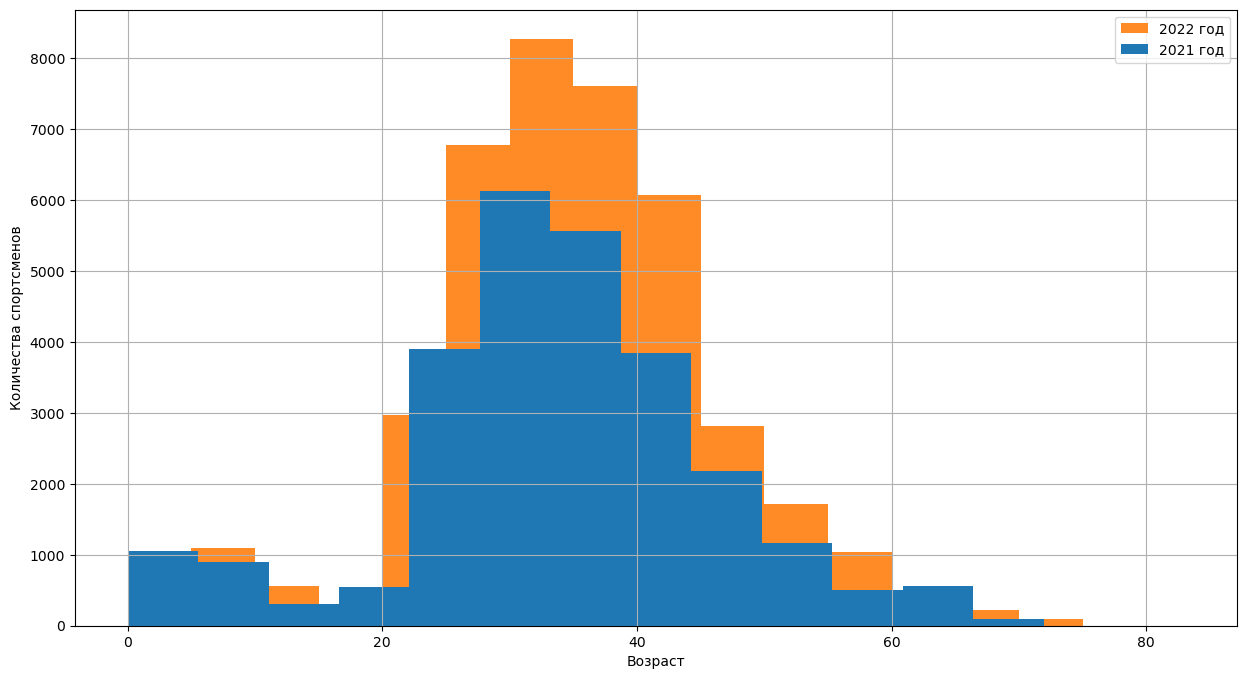

In [32]:
plt.figure(figsize=(15,8))
data2022['age_for_service_date'].hist(bins = 15, alpha = 0.9,  color = 'tab:orange', label = '2022 год')
data2021['age_for_service_date'].hist(bins = 15, alpha = 1, color = 'tab:blue', label = '2021 год')
plt.ylabel('Количества спортсменов')
plt.xlabel('Возраст')
plt.legend()
plt.show()

В возрастном распределении пациентов существенных изменений также не просматривается

## Самые популярные услуги

Определим, какие услуги оказывались чаще всего в 2021 и 2022 годах

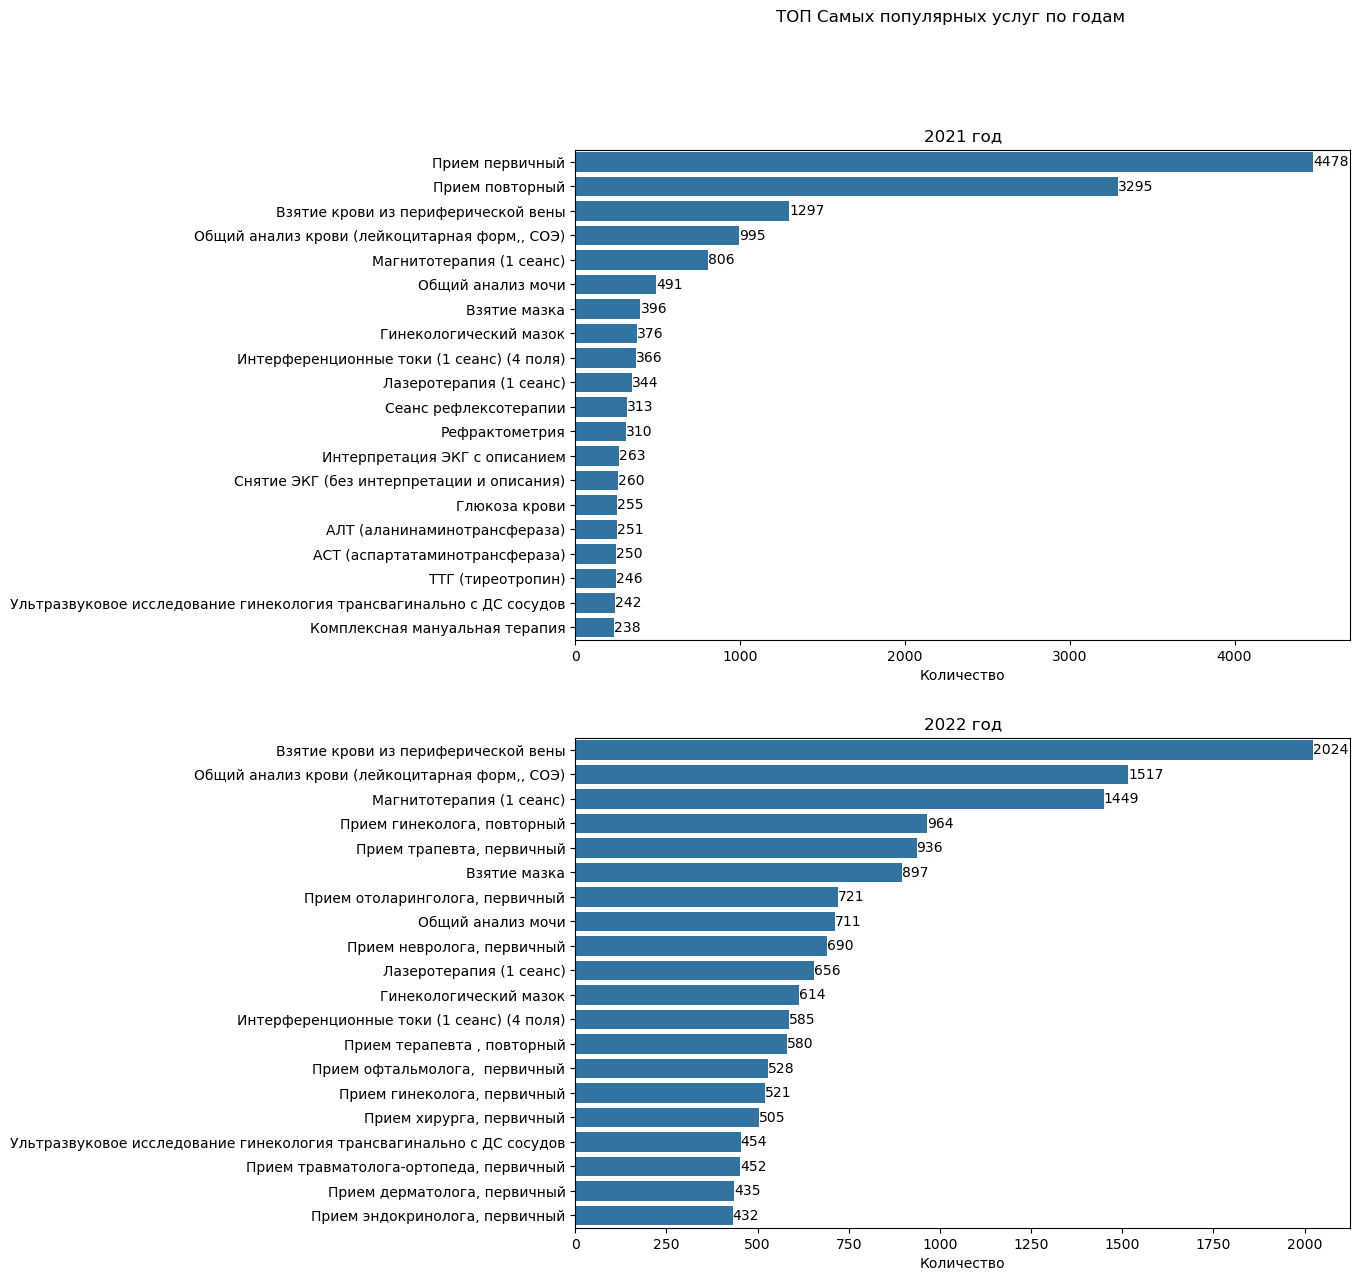

In [33]:
f, ax = plt.subplots(2, 1, figsize=(10,14))
dd = data2021['service_name'].value_counts().head(20)
sns.barplot(x=dd, y=dd.index, color='tab:blue', ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10, label_type='edge', color='black')
ax[0].set_title('2021 год')
ax[0].set_ylabel('')
ax[0].set_xlabel('Количество')

dd = data2022['service_name'].value_counts().head(20)
sns.barplot(x=dd, y=dd.index, color='tab:blue', ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10, label_type='edge', color='black')
ax[1].set_title('2022 год')
ax[1].set_ylabel('')
ax[1].set_xlabel('Количество')


plt.suptitle('ТОП Самых популярных услуг по годам')
plt.show()

В 2022 году из ТОПа услуг вышли первичные и повторные приемы. Но если присмотреться, то видно, что они отдельная услуга "Первичный прием" как бы распределилась по узким специалистам.

In [34]:
data.query('service_name.str.contains("первичный")').groupby(['year'], as_index=False)['service_number'].sum()

,year,service_number
0,2021,7678
1,2022,7361


Количество первичных приемов осталось на том же уровне, просто переименовали услуги

## Рост цен на услуги

Рассчитаем рост прайсовых цен на отдельные услуги.

In [35]:
price2021 = data2021.groupby('service_name', as_index=False)['price'].mean()
price2022 = data2022.groupby('service_name', as_index=False)['price'].mean()
price_compare = pd.merge(price2021, price2022, on='service_name', suffixes=('_2021', '_2022'))
price_compare['Разница'] = price_compare['price_2022'] - price_compare['price_2021']
price_compare['Рост %'] = round(100 * (price_compare['price_2022'] / price_compare['price_2021'] - 1), 2)
price_compare

,service_name,price_2021,price_2022,Разница,Рост %
0,"(Б1 (11))Аллергопанель IgE шерсть кошки, шерсть собаки, шерсть овцы, клещ D,pteroniss, клещ D.farina, пыль домашняя, перо подушки, библиотечная пыль)",1449.00,1520.00,71.00,4.90
1,25-OH витамин D (25-гидроксихолекальциферол),3255.00,3420.00,165.00,5.07
2,CMV (цитомегаловирус) (Кровь),378.00,400.00,22.00,5.82
3,CMV (цитомегаловирус) (Слюна),378.00,400.00,22.00,5.82
4,CMV (цитомегаловирус) (Соскоб),378.00,400.00,22.00,5.82
...,...,...,...,...,...
434,Эпителий собаки,1155.00,1210.00,55.00,4.76
435,Эстрадиол,630.00,677.78,47.78,7.58
436,Эхокардиография с допплеровским анализом,3465.00,3713.73,248.73,7.18
437,альфа-амилаза,287.00,310.34,23.34,8.13


Есть ли услуги, которые подешевели?

In [36]:
price_compare.query('Разница < 0')

,service_name,price_2021,price_2022,Разница,Рост %
149,Исследование мокроты,809.00,600.00,-209.00,-25.83


Есть! Обычно все только дорожает. Перепроверим, нет ли тут ошибки по исходным данным

In [37]:
data.query('service_name == "Исследование мокроты"')

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,date,year,month,week,gender,price
23348,31249288703,2021-08-05,Исследование мокроты,809,1,680921,2.00,29,2021-08-05,2021,8,31,Жен,809.00
54785,32326921703,2022-03-27,Исследование мокроты,600,1,873191,1.00,28,2022-03-27,2022,3,12,Муж,600.00


Ошибки нет =)

Наиболее сильно подорожавшие услуги

In [38]:
price_compare.sort_values(by='Рост %', ascending=False).head(20)

,service_name,price_2021,price_2022,Разница,Рост %
83,Введение лекарственных препаратов в наружный слуховой проход,263.00,308.00,45.00,17.11
139,Интерпретация результатов Диаскинтеста,1103.00,1280.00,177.00,16.05
31,Mycoplasma pneumoniae IgG,599.00,690.00,91.00,15.19
27,Herpes simplex virus 1 IgG,599.00,690.00,91.00,15.19
5,Chlamydia pneumoniae IgG,599.00,690.00,91.00,15.19
28,Herpes simplex virus 1 IgM,599.00,690.00,91.00,15.19
285,Проведение Диаскинтеста,1365.00,1570.00,205.00,15.02
382,"Ультразвуковое исследование большие сроки беременности (II, III триместр)",3045.00,3500.00,455.00,14.94
20,HSV 1 (вирус простого герпеса 1) (Кровь),420.00,480.00,60.00,14.29
42,"Ureaplasma spp, (Соскоб)",420.00,480.00,60.00,14.29


In [39]:
print(f"Средний рост цен на услуги {price_compare['Рост %'].mean():.2f}%")

Средний рост цен на услуги 6.32%


Вполне сопоставимо с ростом показателя "Средняя стоимость одной услуги"

## Дешевые / дорогие услуги

Разобьем услуги на ранги по стоимости: 1 — дешевый, 2 — средний, 3 — дорогой. В качестве границ рангов возьмем значений цен чуть выше и ниже 25 и 75 процентилей.

In [40]:
data['price'].describe()

count   85369.00
mean     1149.46
std       774.94
min       147.00
25%       550.00
50%      1140.00
75%      1530.00
max     26999.00
Name: price, dtype: float64

In [41]:
labels = ['1 дешевые', '2 средние', '3 дорогие']
data2021['price_rank'] = pd.cut(data2021['price'], bins=[0, 600, 1500, 9999999], labels=labels)
data2022['price_rank'] = pd.cut(data2022['price'], bins=[0, 600, 1500, 9999999], labels=labels)

In [42]:
price_rank2021 = data2021.groupby('price_rank', as_index=False).agg({'service_number' : 'sum', 'service_amount' : 'sum', 'insured' : 'nunique'})
price_rank2022 = data2022.groupby('price_rank', as_index=False).agg({'service_number' : 'sum', 'service_amount' : 'sum', 'insured' : 'nunique'})

In [43]:
price_rank_compare = pd.merge(price_rank2021, price_rank2022, on='price_rank', suffixes=('_2021', '_2022'))
price_rank_compare

,price_rank,service_number_2021,service_amount_2021,insured_2021,service_number_2022,service_amount_2022,insured_2022
0,1 дешевые,8549,2908587,1126,11412,3976347,1780
1,2 средние,15221,18086939,1699,16900,18678720,2235
2,3 дорогие,3634,8962026,998,13516,26331595,2670


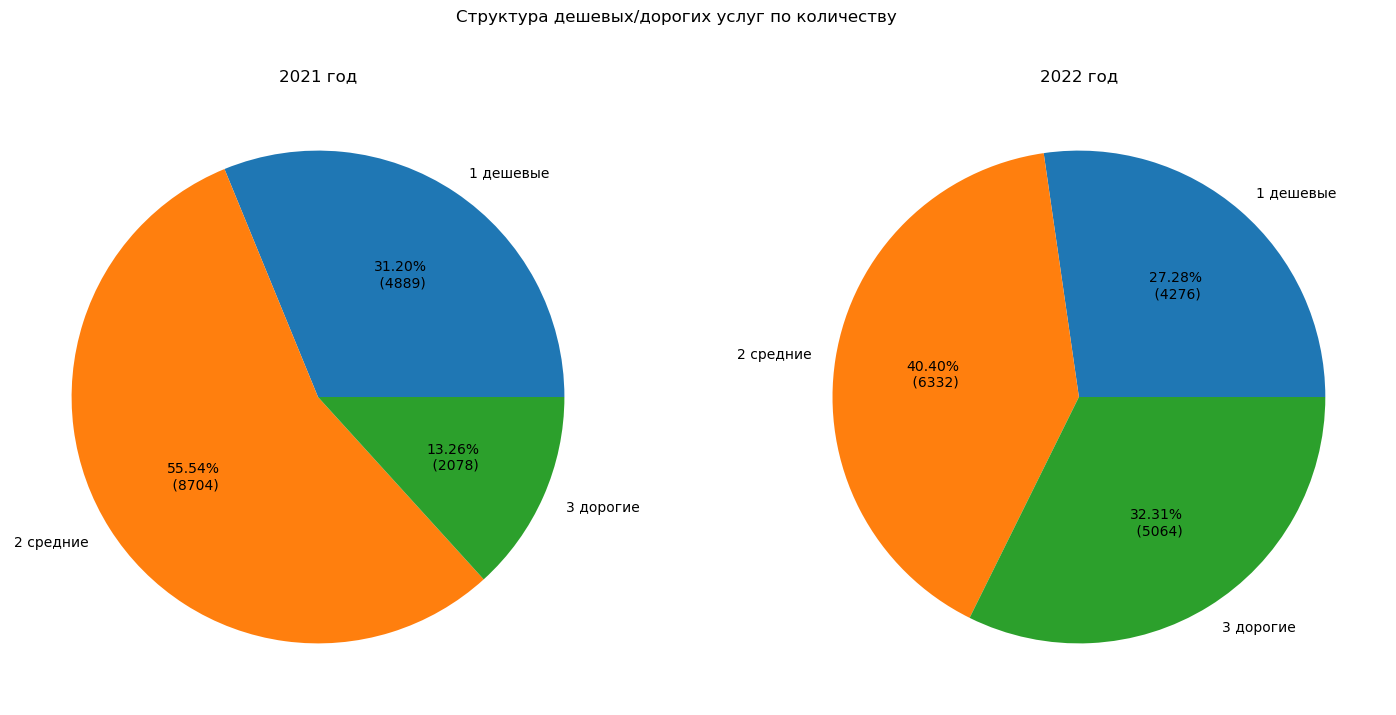

In [44]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
ax[0].pie(x = price_rank2021['service_number'], labels = price_rank2021['price_rank'], 
          autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))
ax[0].set_title('2021 год')

ax[1].pie(x = price_rank2022['service_number'], labels = price_rank2022['price_rank'], 
          autopct=lambda p : '{:.2f}%'.format(p) + '\n ({:.0f})'.format(p*dd.sum()/100))
ax[1].set_title('2022 год')
plt.suptitle('Структура дешевых/дорогих услуг по количеству')
plt.show()

Видим существенное изменение в структуре оказываемых услуг. Существенно выросла доля дорогих услуг. Большей частью потестив услуги среднего ценового диапазона.

# Проверка гипотез

## Гипотеза средняя стоимость обслуживания пациентов изменилась из-за изменения поло-возрастной структуры обслуживаемых пациентов

Как было показано выше поло-возрастная структура пациентов - существенно не поменялась. Проверим это статистическоми методами.

### Оценка изменения гендерной структуры пациентов

Для оценки изменения гендерной структуры пациентов сравним Т-тестом показатель «Доля женщин-пациентов в неделю» в 2022 и 2021 годах. Показатель рассчитывается как количество женщин в неделю ко всем пациентам в неделю.

Установки для статистического теста:

- Нулевая гипотеза — средняя доля женщин среди пациентов в 2022 осталась такой же, как и в 2021.
- Альтернативная гипотеза — средняя доля женщин среди пациентов в 2022 году изменилась.
- Критический уровень p-value примем в 0.05.

In [45]:
gender2021 = data2021.query('gender == "Жен"').groupby('week')['insured'].nunique() / data2021.groupby('week')['insured'].nunique()
gender2022 = data2022.query('gender == "Жен"').groupby('week')['insured'].nunique() / data2021.groupby('week')['insured'].nunique()

In [46]:
test_selection(gender2021, gender2022,
               h0='Средняя доля женщин среди пациентов в 2022 осталась такой же как и в 2021',
               h1='Средняя доля женщин среди пациентов в 2022 году изменилась')

Первая выборка размером 36 прошла проверку на нормальное распределение. pval = 0.08677681112639805
Вторая выборка размером 36 прошла проверку на нормальное распределение. pval = nan
Дисперсии выборок близки. pval = nan. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value nan
НЕ можем отвергнуть нулевую гипотезу, принимаем ее:
 ------>  Средняя доля женщин среди пациентов в 2022 осталась такой же как и в 2021 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value nan
НЕ можем отвергнуть нулевую гипотезу, принимаем ее:
 ------>  Средняя доля женщин среди пациентов в 2022 осталась такой же как и в 2021 


Т-Тест показал, что доля женщин среди пациентов в 2022 осталась такой же как и в 2021. А если гендерное распределение пациентов не измеилось, то и повлиять на целевой показательно оно не могло.

### Оценка изменения возрастной структуры

Для оценки изменения возрастной структуры пациентов сравним сравним Т-тестом показатель «Средний возраст пациентов» в 2022 и 2021 годах. Возраст берется напрямую из выборки. 

Установки для статистического теста: 
- Нулевая гипотеза — Средний возраст пациентов в 2022 остался такой же, как и в 2021
- Альтернативная гипотеза — Средний возраст пациентов в 2022 году изменился
- Критический уровень p-value примем в 0.05.

In [47]:
test_selection(data2021['age_for_service_date'], data2022['age_for_service_date'], 
               h0='Средний возраст пациентов в 2022 остался такой же как и в 2021', 
               h1='Средний возраст пациентов в 2022 году изменился')

Первая выборка размером 26736 НЕ прошла проверку на нормальное распределение. pval = 3.041753950487549e-153
Вторая выборка размером 40977 НЕ прошла проверку на нормальное распределение. pval = 6.357485607115983e-270
Дисперсии выборок НЕ близки. pval = 5.841879464421106e-11. Применяем equal_var=False

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 3.802844013179289e-05
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Средний возраст пациентов в 2022 году изменился 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 3.3755706946223943e-05
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  Средний возраст пациентов в 2022 году изменился 


Т-Тест показал, что средний возраст пациентов в 2022 году изменился

Оценим насколько изменился возраст

In [48]:
avg_age2021 = data2021['age_for_service_date'].mean()
avg_age2022 = data2022['age_for_service_date'].mean()
agedif = 100 * (avg_age2022 / avg_age2021 - 1)
print(f'Средний возраст в 2021 году {avg_age2021:.1f} лет')
print(f'Средний возраст в 2022 году {avg_age2022:.1f} лет')
print(f'% изменения среднего возраста пациентов {agedif:.2f}%')

Средний возраст в 2021 году 33.8 лет
Средний возраст в 2022 году 34.2 лет
% изменения среднего возраста пациентов 1.17%


Средний возраст изменился всего на 1%. Это оказалось достаточно для статистически значимой достоверности разницы. Учтем это при следующей проверке

## Гипотезы Средняя стоимость обслуживания пациентов изменилась из-за изменения показателя N

Остальные гипотезы однотипные: проверка зависимости стоимости обслуживания пациентов от другого показателя. Проверить взаимосвязь численных показателей можно с помощью корреляции.

В этом случае гипотеза формулируется так: «Есть взаимосвязь между стоимостью обслуживания пациентов и ...» Критерием будет коэффициент корреляции. 

Интерпретация коэффициента корреляции по шкале Чеддока:

- От 0 до 0,3 — очень слабая
- От 0,3 до 0,5 — слабая
- От 0,5 до 0,7 — средняя
- От 0,7 до 0,9 — сильная (высокая)
- От 0,9 до 1,0 — очень сильная (очень высокая)

Для принятия гипотезы о взаимосвязи установим, что корреляция должна быть средней и выше, то есть коэффициент корреляции в соответствующей паре показателей должен быть больше 0,5.

Оценку корреляции показателей будем проводить на показателях "в неделю": «общее количество пациентов в неделю», «общее количество услуг в неделю», «общая стоимость услуг в неделю» и т. д., так у нас наберется достаточно большая выборка.

### Формируем таблицу недельных показателей

Отфильтровывать осенние месяцы 2021 года здесь уже не требуется - берем все данные

In [49]:
#Вновь назначим ранги для цен на услуги уже по всему датасету
data['price_rank'] = data['price'].apply(lambda x: 1 if x < 600 else (2 if x < 1500 else 3))

#Формируем таблицу основных показателей
week_data = data.groupby(['year', 'week']).agg({'insured' : 'nunique', 
                                          'service_amount' : 'sum', 
                                          'service_number' : 'sum', 
                                          'age_for_service_date' : 'mean', 
                                          'sex_id' : 'mean', 
                                          'price_rank' : 'sum'})

#Переименовываем колонки показателей
week_data = week_data.rename(columns = {'insured' : 'Пациенты', 
                            'service_amount' : 'Стомость услуг', 
                            'service_number' : 'Колво услуг', 
                            'age_for_service_date' : 'Возраст', 
                            'sex_id' : 'Гендер', 
                            'price_rank' : 'Цены'})

#Визиты вычисляем отдельно
dd = data.groupby(['date']).agg({'year' : 'first', 'week': 'first', 'insured' : 'nunique'})
week_data['Визиты'] = dd.groupby(['year', 'week'])['insured'].sum()

#Гендер - доля женщин среди пациентов
week_data['Гендер'] = week_data['Гендер'] - 1

#Дополняем таблицу расчетными средними показателями
week_data['Цены'] = week_data['Цены'] / week_data['Колво услуг']
week_data['Стоимость обслуживания пациента'] = week_data['Стомость услуг'] / week_data['Пациенты']
week_data['Стоимость 1 услуги'] = week_data['Стомость услуг'] / week_data['Колво услуг']
week_data['Стоимость 1 визита'] = week_data['Стомость услуг'] / week_data['Визиты']
week_data['Колво услуг на пациента'] = week_data['Колво услуг'] / week_data['Пациенты']

week_data

Пациенты  Стомость услуг  Колво услуг  Возраст  Гендер  Цены  \
year week                                                                 
2021 1           86          486654          461    36.59    0.52  1.79   
     2          110          548666          517    34.97    0.68  1.77   
     3          127          564126          493    32.96    0.63  1.81   
     4          134          627819          551    31.94    0.69  1.83   
     5          133          593734          576    34.42    0.71  1.74   
...             ...             ...          ...      ...     ...   ...   
2022 31         120          694670          555    37.28    0.64  2.14   
     32         137          915895          776    36.06    0.65  2.02   
     33         130          758447          639    35.99    0.62  2.04   
     34         142          884595          735    33.80    0.74  2.01   
     35          95          464172          386    34.33    0.69  2.06   

           Визиты  Стоимость обслуживания пациента  Стоимость 1 услуги  \
year week                                                                
2021 1        151                          5658.77             1055.65   
     2        182                          4987.87             1061.25   
     3        189                          4441.94             1144.27   
     4        209                          4685.22             1139.42   
     5        212                          4464.17             1030.79   
...           ...                              ...                 ...   
2022 31       191                          5788.92             1251.66   
     32       253                          6685.36             1180.28   
     33       225                          5834.21             1186.93   
     34       253                          6229.54             1203.53   
     35       123                          4886.02             1202.52   

           Стоимость 1 визита  Колво услуг на пациента  
year week                                               
2021 1                3222.87                     5.36  
     2                3014.65                     4.70  
     3                2984.79                     3.88  
     4                3003.92                     4.11  
     5                2800.63                     4.33  
...                       ...                      ...  
2022 31               3637.02                     4.62  
     32               3620.14                     5.66  
     33               3370.88                     4.92  
     34               3496.42                     5.18  
     35               3773.76                     4.06  

[88 rows x 11 columns]

### Проверим выборки по каждому отдельному показателю на нормальность

В таблице ниже 3 первые колонки — тесты на нормальное распределение выборок показателей в целом, отдельно в 2021 и 2022 году. Начальные установки для теста:

- Нулевая гипотеза — что выборка имеет нормальное распределение.
- Альтернативная — что выборка не имеет нормального распределения.
- Критическое значение для p-value — 0.05.

В таблицу заносятся значения p-value тестов соответствующих выборок. Если p-value меньше 0.05, то проверка на нормальность не прошла, распределение выборки не имеет вид нормального распределения. Ячейки со значением меньше 0.05 подсвечиваются оранжевым.

**4 и 5 колонка — сравнение средних выборок в 2021 и 2022 году**

Проверим статистическую значимость роста показателей в 2022 году относительно 2021 года. Для проверки используем Т-тест и тест Mann-Whitney. Если проверка на нормальность не проходит для большинства показателей, то больше доверия тесту Манна-Уитни. 

Начальные установки для теста:
- Нулевая гипотеза — что средние выборок соответствующих показателей одинаковые.
- Альтернативная — что среднее значение выборки в 2022 году больше.
- Критическое значение для p-value — 0.05.

Если p-value меньше 0.05, это означает, что не можем принять нулевую гипотезу, принимаем альтернативную, то есть что среднее значение соответствующего показателя в 2022 году больше, чем в 2021 году. Ячейки со значением меньше 0.05 подсвечиваются оранжевым.

In [50]:
test_paramets = pd.DataFrame([])
cols = set(week_data.columns)
for c in cols:
    test_paramets.loc[c, 'norm'] = stats.normaltest(week_data[c])[1]    
    test_paramets.loc[c, 'norm2021'] = stats.normaltest(week_data.loc[(2021,)][c])[1]
    test_paramets.loc[c, 'norm2022'] = stats.normaltest(week_data.loc[(2022,)][c])[1]
    
    test_paramets.loc[c, 't_test'] = stats.ttest_ind(week_data.loc[(2022,)][c], 
                                                     week_data.loc[(2021,)][c], 
                                                     alternative='greater', equal_var=False)[1]
    
    test_paramets.loc[c, 'm-w_test'] = stats.mannwhitneyu(week_data.loc[(2022,)][c], 
                                                          week_data.loc[(2021,)][c], 
                                                          alternative='greater')[1]   
test_paramets.style.apply(highlight_stat)

,norm,norm2021,norm2022,t_test,m-w_test
Стоимость 1 услуги,0.000000,0.000001,0.926775,0.000000,0.000000
Пациенты,0.814083,0.000512,0.259886,0.000001,0.000000
Цены,0.000006,0.243477,0.740020,0.000000,0.000000
Стомость услуг,0.937560,0.031392,0.295792,0.000000,0.000000
Возраст,0.169316,0.399732,0.379932,0.007346,0.028638
Колво услуг,0.929945,0.013335,0.264662,0.000002,0.000000
Стоимость 1 визита,0.654926,0.612671,0.926974,0.000000,0.000000
Визиты,0.782711,0.003456,0.283901,0.000003,0.000000
Гендер,0.008015,0.000580,0.613234,0.242056,0.169823
Колво услуг на пациента,0.043611,0.150545,0.288014,0.237644,0.171988


### Таблица корреляций показателей

Так как в целом тест на нормальность прошли далеко не все показатели, для вычисления коэффициентов корреляции применяем метод Спирмана.

В ячейках таблицы — коэффициенты корреляции пары показателей, соответствующих строки и колонки. Значения больше 0,5, то есть для которых гипотеза о взаимосвязи принимается, подсвечиваются зеленым.

In [51]:
spearman_corr = week_data.corr(method='spearman')
spearman_corr[['Стоимость обслуживания пациента']].style.apply(highlight_over, color='lime', p=0.5)

,Стоимость обслуживания пациента
Пациенты,0.295220
Стомость услуг,0.503557
Колво услуг,0.482756
Возраст,0.259853
Гендер,-0.076609
Цены,0.369395
Визиты,0.381694
Стоимость обслуживания пациента,1.000000
Стоимость 1 услуги,0.357173
Стоимость 1 визита,0.800800


Определим еще и коэффициенты корреляции по Пирсону.

In [52]:
pearson_corr = week_data.corr(method='pearson')
pearson_corr[['Стоимость обслуживания пациента']].style.apply(highlight_over, color='lime', p=0.5)

,Стоимость обслуживания пациента
Пациенты,0.352145
Стомость услуг,0.530390
Колво услуг,0.516281
Возраст,0.336914
Гендер,-0.188303
Цены,0.416566
Визиты,0.435693
Стоимость обслуживания пациента,1.000000
Стоимость 1 услуги,0.416410
Стоимость 1 визита,0.707787


Тест Спирмана показывает взаимосвязи «Стоимости обслуживания пациента» и показателей «Стоимость услуг», «Стоимость 1 визита», «Услуг на пациента», причем последние два показател имеют сольную корреляцию.

Тест корреляции по Пирсону также показывает корреляции «Стоимости обслуживания пациента» с показателями «Кол-во услуг». Причем этот показатель в тесте Спирмана чуть-чуть не хватило до уровня средней корреляции в 0.5.

Принимаем гипотезу, что изменение показателя «Стоимость обслуживания пациента» имеет взаимосвязь с изменениями показателей «Стоимость услуг», «Стоимость одного визита», «Кол-во услуг на пациента», «Кол-во услуг».

### Коэффициенты линейной аппроксимации выявленных зависимостей показателей

Оценим, насколько изменения выявленных показателей с высокой корреляцией влияют на целевой показатель.
Для этого построим линейные аппроксимации зависимости целевого показателя «Стоимость обслуживания пациента» от выявленных.

Так как требудется количественну относительную оценку взаимовлияния показателей, смаштабируем все показатели до диапазона [0..1] делением на максимальное значение

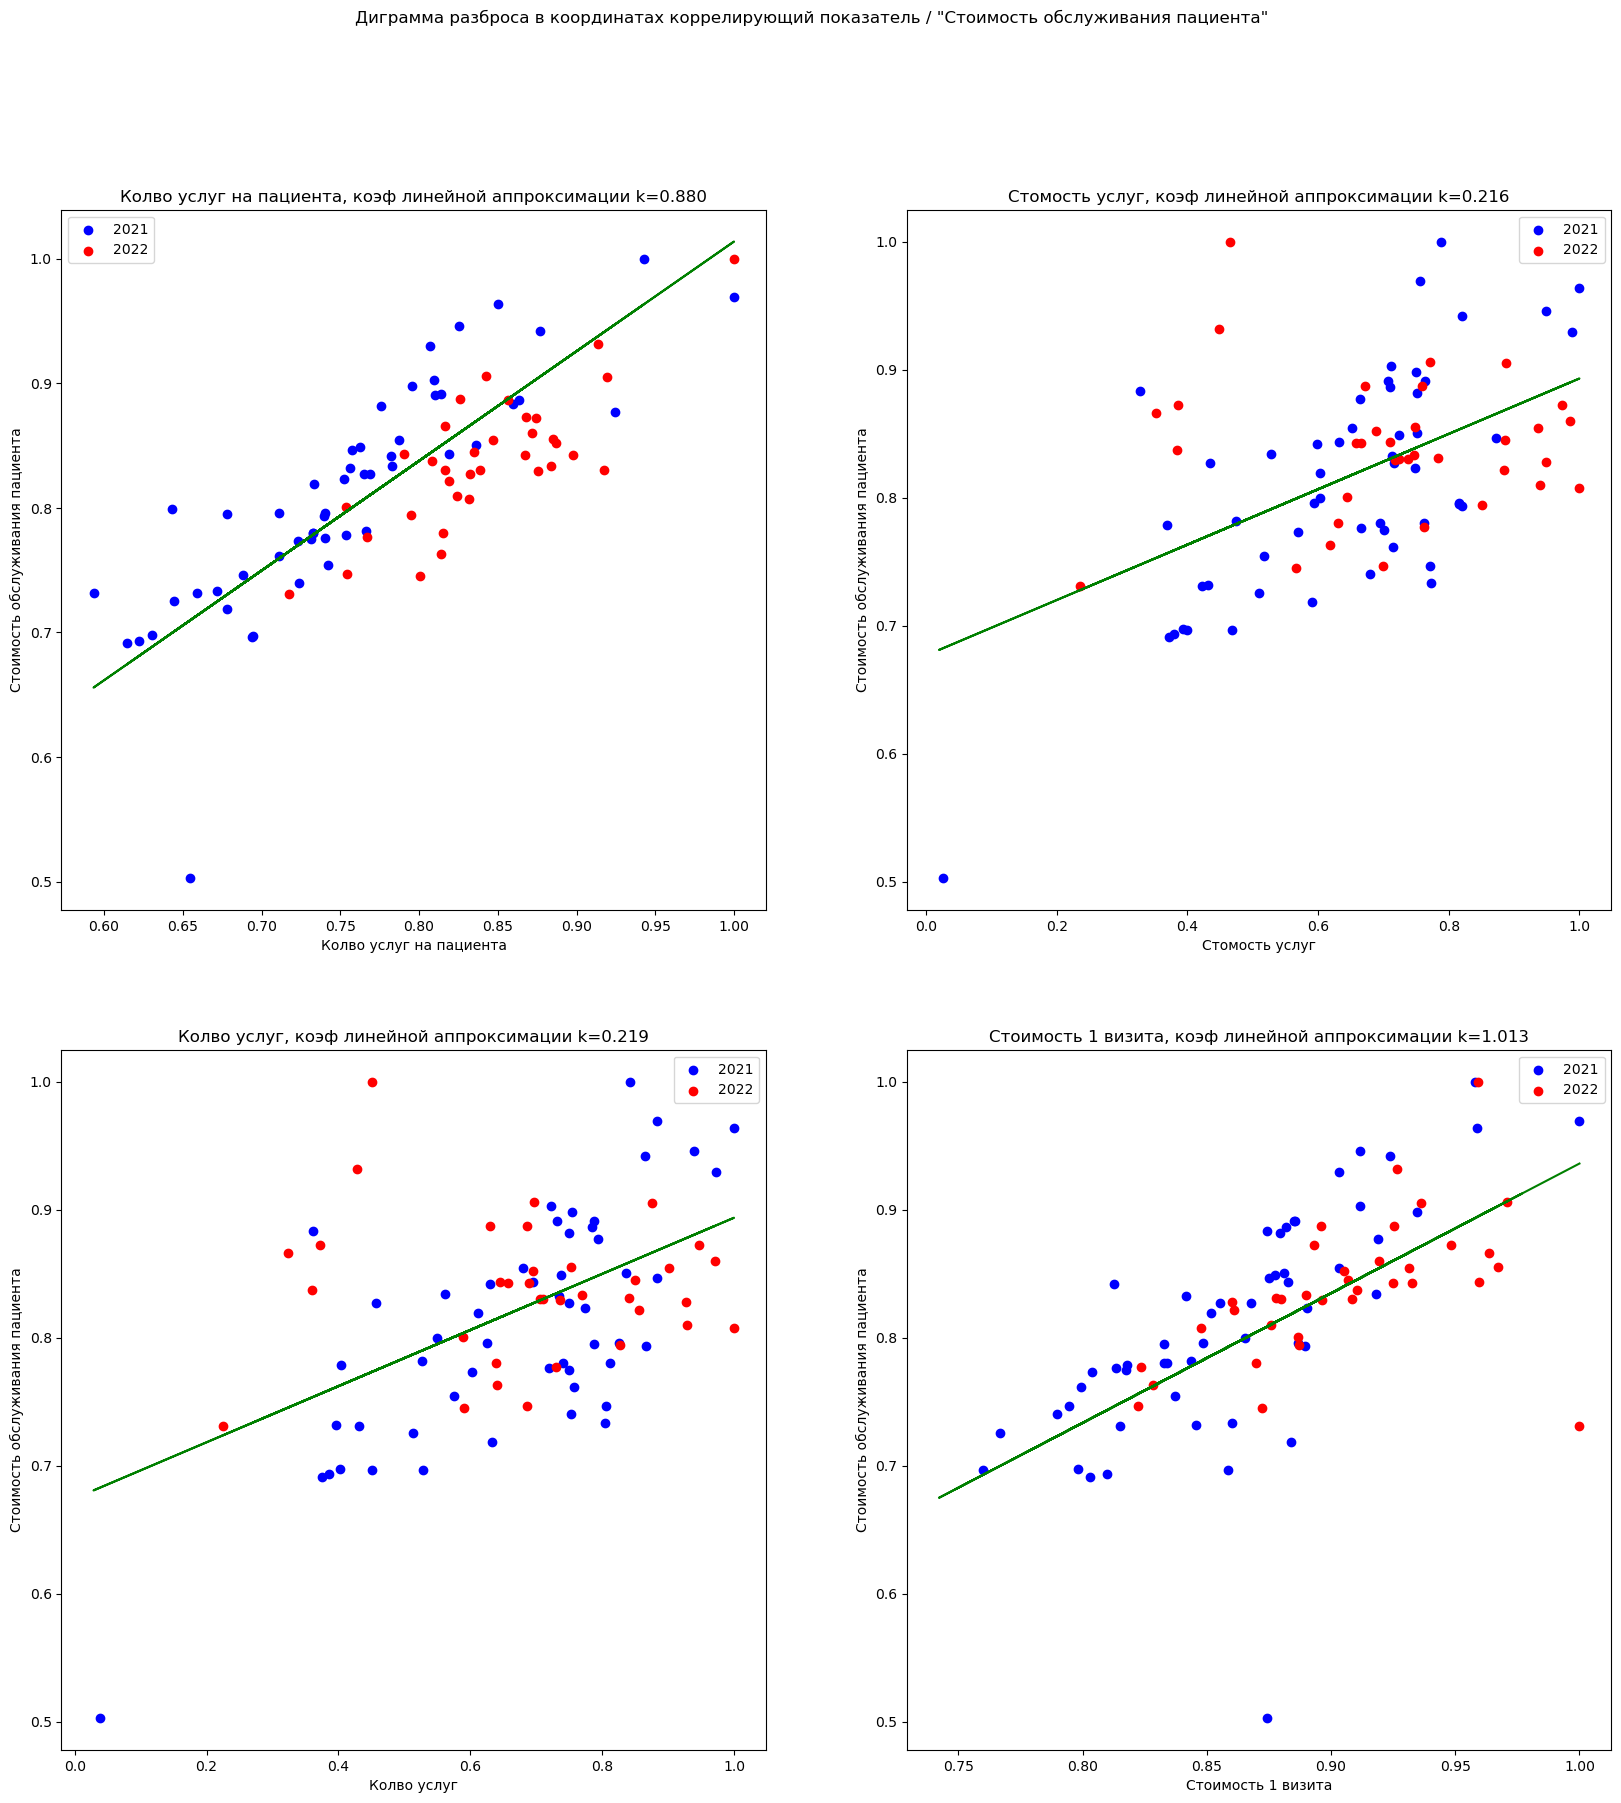

In [53]:
cols = set(pearson_corr.query('0.5 < `Стоимость обслуживания пациента` < 0.99').index)
i = 0
ddd = pd.DataFrame([])
ddd2021 = pd.DataFrame([])
ddd2022 = pd.DataFrame([])

f, ax = plt.subplots(len(cols) // 2 + (len(cols) % 2), 2, figsize=(20,20))

ddd['y'] = week_data['Стоимость обслуживания пациента'] / week_data['Стоимость обслуживания пациента'].max()

ddd2021['y'] = week_data.loc[(2021,)]['Стоимость обслуживания пациента'] / \
                week_data.loc[(2021,)]['Стоимость обслуживания пациента'].max()
    
ddd2022['y'] = week_data.loc[(2022,)]['Стоимость обслуживания пациента'] / \
                week_data.loc[(2022,)]['Стоимость обслуживания пациента'].max()
for cc in cols:
    #График диаграммы разброса
    ddd2021['x'] = week_data.loc[(2021,)][cc] / week_data.loc[(2021,)][cc].max()
    ddd2022['x'] = week_data.loc[(2022,)][cc] / week_data.loc[(2022,)][cc].max()
    ax[i // 2, i % 2].scatter(ddd2021['x'], ddd2021['y'], color='blue', label='2021')
    ax[i // 2, i % 2].scatter(ddd2022['x'], ddd2022['y'], color='red', label='2022')
    ax[i // 2, i % 2].legend()
    
    #Линейная аппроксимация
    ddd['x'] = week_data[cc] / week_data[cc].max()
    z = np.polyfit(ddd['x'], ddd['y'], 1)
    p = np.poly1d(z)
    ax[i // 2, i % 2].plot(ddd['x'], p(ddd['x']), color='green')

    
    ax[i // 2, i % 2].set_title(f'{cc}, коэф линейной аппроксимации k={z[0]:.3f}')
    ax[i // 2, i % 2].set_ylabel('Стоимость обслуживания пациента')
    ax[i // 2, i % 2].set_xlabel(cc)
    i = i + 1
plt.suptitle('Диграмма разброса в координатах коррелирующий показатель / "Стоимость обслуживания пациента"')
plt.show()   

Интерпретация:

- При изменении показателя «Cтоимости визита» на 1%, стоимость обслуживания пациента изменится также на 1%
- При изменении показателя «Услуг на пациента» на 1%, стоимость обслуживания пациента изменится на 0.9%
- При изменении показателя «Кол-во услуг» на 1%, стоимость обслуживания пациента изменится на 0.2%
- При изменении показателя «Стоимость услуг» на 1%, стоимость обслуживания пациента изменится также на 0.2%

Однако, учитывая, что сила корреляции последних двух показателей "средняя", их влияние на стоимость обслуживания пациента может быть значительно меньше.

## Основные драйверы изменения средней стоимости обслуживания пациентов

Основными драйверами изменения средней стоимости обслуживания пациента стали изменения показателей «Стоимости визита» и «Услуг на пациента».

In [54]:
#Напомним таблицу сравнения показателей год к году
compare

,Показатель,2021,2022,Разница,Рост %
0,Общее количество услуг,26736.00,40977.00,14241.00,53.27
1,Общее количество пациентов,1733.00,2757.00,1024.00,59.09
2,Общая стомиость услуг,29957552.00,48986662.00,19029110.00,63.52
3,Общее количество визитов,9407.00,14434.00,5027.00,53.44
4,Общее количество кейсов,2859.00,4338.00,1479.00,51.73
5,Средняя стоимость одной услуги,1120.49,1195.47,74.98,6.69
6,*** Средняя стоимость обслуживания пациента ***,17286.53,17768.10,481.57,2.79
7,Средняя стоимость одного визита,3184.60,3393.84,209.24,6.57
8,Средняя стоимость одного кейса,10478.33,11292.45,814.12,7.77
9,Среднее количество услуг на пациента,15.43,14.86,-0.57,-3.69


Причем эти двайверы изменились разнонаправленно: стоимость визита выросла на 6,57% (очевидно, из-за общего роста цен), а услуг на одного пациента было оказано меньше на 3,69%. В итоге средняя стоимость обслуживания пациента выросла только на 2,8%.

Падение показателя «Услуг на пациента» может быть связано с увеличением количества «одноразовых» пациентов, которые пришли, сдали один тест и больше в клинику не приходили.

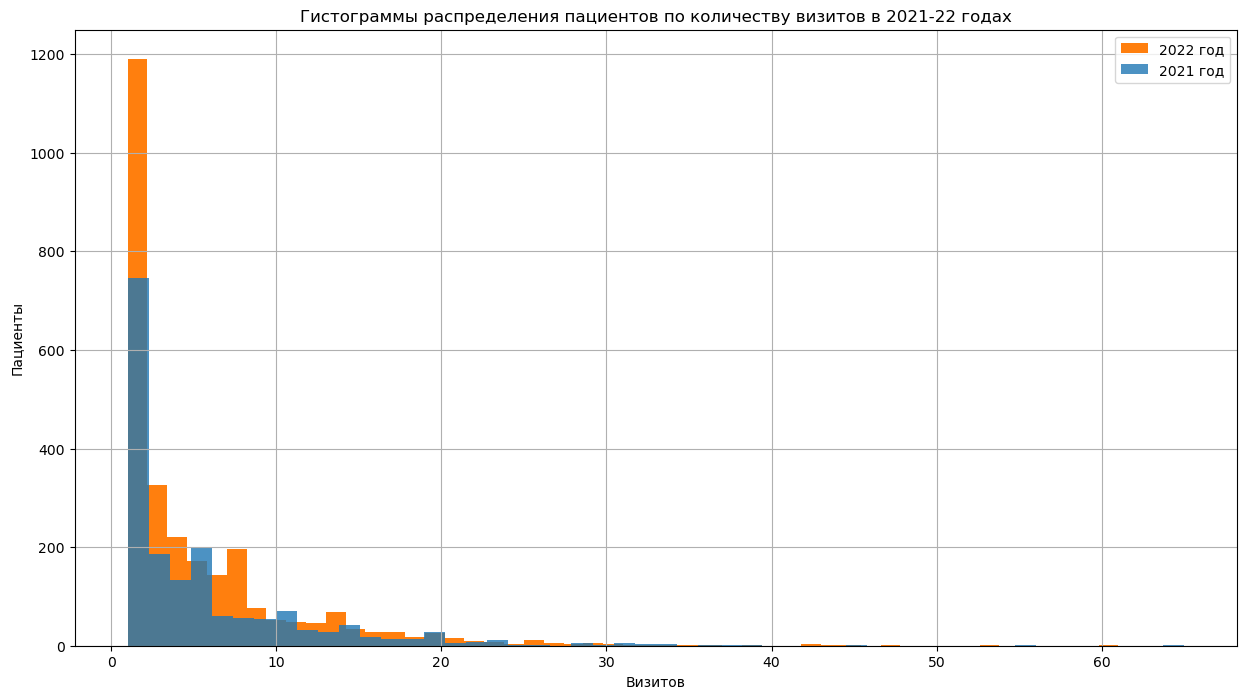

In [55]:
plt.figure(figsize=(15,8))
data2022.groupby('insured')['date'].nunique().hist(bins = 50 , alpha = 1,  color = 'tab:orange', label = '2022 год')
data2021.groupby('insured')['date'].nunique().hist(bins = 50 , alpha = 0.8, color = 'tab:blue', label = '2021 год')
plt.ylabel('Пациенты')
plt.xlabel('Визитов')
plt.title('Гистограммы распределения пациентов по количеству визитов в 2021-22 годах')
plt.legend()
plt.show()